<a href="https://colab.research.google.com/github/Jaesu26/korean-aspect-based-sentiment-analysis/blob/main/2022-10-30-%EC%86%8D%EC%84%B1%EA%B8%B0%EB%B0%98-%EA%B0%90%EC%84%B1-%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2022 국립국어원 인공지능 언어능력평가

In [1]:
!nvidia-smi

Sun Oct 30 10:27:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (6,926 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [2]:
!pip install soynlp
!pip install emoji
!pip install transformers==4.8.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


`-` 런타임 재시작

## 데이터 불러오기

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import random
import json
import os
import gc
import re
import emoji

from soynlp.normalizer import repeat_normalize

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score

from typing import Any, Callable, Dict, List, Optional, Sequence, Tuple, Union
from numpy.typing import NDArray

from tqdm.auto import tqdm
from glob import glob

warnings.filterwarnings('ignore') 

In [4]:
from google.colab import drive

drive.mount('/content/drive')  ## 구글코랩과 구글드라이브 연결

Mounted at /content/drive


In [5]:
%cd  '/content/drive/MyDrive/Colab Notebooks/속성기반-감성-분류'

/content/drive/MyDrive/Colab Notebooks/속성기반-감성-분류


- 데이터 불러오기

In [6]:
JsonType = Dict[str, Any]

In [7]:
train_path = './data/nikluge-sa-2022-train.jsonl'
valid_path = './data/nikluge-sa-2022-dev.jsonl'
test_path = './data/nikluge-sa-2022-test.jsonl'
submission_path = './data/nikluge-sa-2022-submission5.json'

In [8]:
def load_jsonl(file_path: str) -> List[JsonType]:
    """jsonl 파일을 읽어서 list에 저장"""
    json_list = []
    with open(file_path, encoding='utf-8') as f:
        for line in f.readlines():
            json_list.append(json.loads(line))
    return json_list

In [9]:
def write_jsonl(jsonl: List[JsonType], file_path: str) -> None:
    """jsonl 파일을 write"""
    with open(file_path, mode='w', encoding='utf-8') as f: 
        for j in jsonl: 
            f.write(json.dumps(j, ensure_ascii=False) + '\n')

In [10]:
def jsonl2df(jsonl: List[JsonType]) -> pd.DataFrame:
    """
    jsonl을 dataframe으로 변경한 후 반환
    For entity property classification
    """
    ids = []
    texts = []
    entity_properties = []
    sentiments = []
    
    for json in jsonl:
        annotations = json['annotation']
        ids.append(json['id'].split('-')[-1])
        texts.append(json['sentence_form'])
        entity_properties.append([annotation[0] for annotation in annotations])
        sentiments.append([annotation[2] for annotation in annotations])
        
    df = pd.DataFrame({'id':ids,
                        'text':texts,
                        'entity_property':entity_properties,
                        'sentiment':sentiments})
    
    return df

In [11]:
def to_tidy(df: pd.DataFrame) -> pd.DataFrame:
    """
    entity_property 변수가 한 행에 하나의 개체 속성만 가지도록 변환
    For visualization and sentiment classification
    """
    list_df = df.to_numpy().tolist()
    ids = []
    texts = []
    entity_properties = []
    sentiments = []

    for id, text, entity_property, sentiment in list_df:
        if not entity_property:
            entity_property = [[]]
        if not sentiment:
            sentiment = [[] for _ in range(len(entity_property))]

        for e, s, in zip(entity_property, sentiment):
            ids.append(id)
            texts.append(text)
            entity_properties.append(e)
            sentiments.append(s) 

    df = pd.DataFrame({'id':ids,
                       'text':texts,
                       'entity_property':entity_properties,
                       'sentiment':sentiments})
    return df

In [234]:
def to_untidy(df: pd.DataFrame) -> pd.DataFrame:
    ids = []
    texts = []
    entity_properties = [] 
    sentiments = [] 

    for id in sorted(df['id'].unique()):
        tmp = df.query('id == @id')
        ids.append(id)
        texts.append(tmp['text'].values[0])
        if isinstance(tmp['entity_property'].tolist()[0], list):  ## [[]] 
            entity_properties.append(tmp['entity_property'].tolist()[0])
            sentiments.append(tmp['sentiment'].tolist()[0])
        else:
            entity_properties.append(tmp['entity_property'].tolist())
            sentiments.append(tmp['sentiment'].tolist())

    df = pd.DataFrame({'id':ids,
                       'text':texts,
                       'entity_property':entity_properties,
                       'sentiment':sentiments})
    return df

In [173]:
df = jsonl2df(load_jsonl(train_path))
tidy_df = to_tidy(df)

valid = jsonl2df(load_jsonl(valid_path))
tidy_valid = to_tidy(valid)

test = jsonl2df(load_jsonl(test_path))

In [174]:
tidy_df = tidy_df.drop_duplicates().reset_index().drop('index', axis=1)  ## 주석되는 요인만 다른 경우
tidy_valid = tidy_valid.drop_duplicates().reset_index().drop('index', axis=1)

In [15]:
tidy_df.head() 

,id,text,entity_property,sentiment
0,00001,둘쨋날은 미친듯이 밟아봤더니 기어가 헛돌면서 틱틱 소리가 나서 경악.,본품#품질,negative
1,00002,"이거 뭐 삐꾸를 준 거 아냐 불안하고, 거금 투자한 게 왜 이래.. 싶어서 정이 확...",본품#품질,negative
2,00003,간사하게도 그 이후에는 라이딩이 아주 즐거워져서 만족스럽게 탔다.,제품 전체#일반,positive
3,00004,샥이 없는 모델이라 일반 도로에서 타면 노면의 진동 때문에 손목이 덜덜덜 떨리고 이...,제품 전체#일반,neutral
4,00005,안장도 딱딱해서 엉덩이가 아팠는데 무시하고 타고 있다.,본품#일반,negative


- 하이퍼파라미터 (개체 속성과 감성)

In [16]:
MODEL_PATHS = {'electra':'kykim/electra-kor-base', 
               'bert':'kykim/bert-kor-base',}

MODEL_NAME = 'bert'
MODEL_DEFAULT_WEIGHT_PATHS = {'ACD':f'acd_{MODEL_NAME}_default_weight.pt', 
                              'ASC':f'asc_{MODEL_NAME}_default_weight.pt'} 

SAVE_PATHS = {'ACD':'./acd_weight',
              'ASC':'./asc_weight'}

NUM_CLASSES = {'ACD':len(tidy_df['entity_property'].unique()),   
               'ASC':len(tidy_df['sentiment'].unique())}
NUM_FOLDS = 3
NUM_EPOCHS = {'ACD':40, 'ASC':20}
MAX_LEN = 53
BATCH_SIZE = 64
LEARNING_RATE = {'ACD':5e-5, 'ASC':8e-6}
LABEL_SMOOTHING = 0.1
SEEDS = [2022, 2001, 22]  ## seed ensemble
NUM_FOLDS = len(SEEDS) 

- 가중치 저장폴더

In [ ]:
def create_folder(path: str) -> None:
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError as error:
        print(error)

In [ ]:
create_folder(SAVE_PATHS['ACD'])
create_folder(SAVE_PATHS['ASC'])

## 시각화

### 라벨

In [17]:
plt.rc('font', family='NanumBarunGothic')

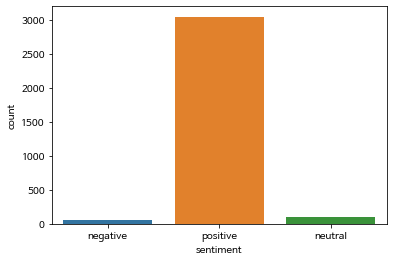

In [18]:
sns.countplot(tidy_df['sentiment'])

`-` 라벨 불균형이 매우 심하다

`-` 하지만 평가 산식은 단순히 라벨을 맞췄냐 못맞췄냐로만 판단한다

`-` 즉, 단순 `f1 score`이므로 적은 클래스의 카테고리는 내다 버려도 좋은 점수를 얻을 수 있다

`-` 속성 기반 감성 분류인데 감성 대부분이 긍정이므로 사실상 속성 분류 테스크와 같다

`-` 그런데 train과 test의 분포가 다르다면?......

`-` 무작위로 샘플링했다면 둘의 분포가 비슷할 것이다

### 개체 속성

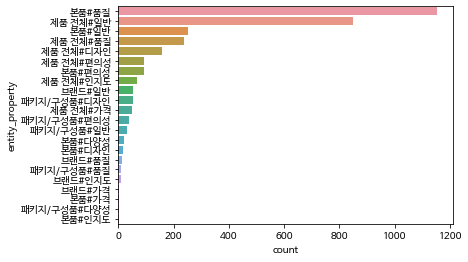

In [19]:
sns.countplot(y=tidy_df['entity_property'], order=tidy_df['entity_property'].value_counts().index) 

`-` 개체 속성도 불균형이 심하다

`-` 하지만 단순히 맞췄냐 못맞췄냐로 판단하므로 적은 클래스는 내다 버려도 좋은 점수를 얻을 수 있다

### 텍스트

In [ ]:
df['text'].str.len().describe()

count    3001.00000
mean       33.91103
std        20.15056
min         1.00000
25%        19.00000
50%        30.00000
75%        44.00000
max       161.00000
Name: text, dtype: float64

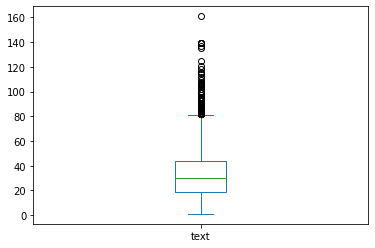

In [ ]:
df['text'].str.len().plot.box()

In [20]:
emoji_dict = {'👍':'좋다',
              '👍🏻':'좋다',
              '★':'좋다',
              '❤':'좋다',
              '♥️':'좋다',
              '♥':'좋다',
              '💕':'좋다',
              '💖':'좋다',
              '❣️':'좋다',
              '💜':'좋다',
              '💛':'좋다',
              '♡':'좋다',
              '😄':'좋다',
              '😊':'좋다',
              '😁':'좋다',
              '😍':'좋다',
              '🤩':'좋다',
              '🤗':'좋다',
              '😆':'좋다',
              '😀':'좋다',
              '👌':'좋다',
              '👏':'좋다',
              '✨':'좋다',
              '^^':'좋다',
              '>_<':'좋다',
              '^-^':'좋다',
              '+_+':'좋다',
              ':)':'좋다',}

In [ ]:
def check_hashtag_df(texts: Sequence[str]) -> Dict[str, int]:
    """해시태그의 document frequency를 계산"""
    hashtag_dict = {}
    for text in texts:
        text = text.lower()
        words = text.split()
        duplicate = {}
        for word in words:
            if '#' in word and word not in duplicate:
                if word not in hashtag_dict:
                    hashtag_dict[word] = 1
                else:
                    hashtag_dict[word] += 1
                duplicate[word] = True

    hashtag_dict.update({'고유한 해시태그 개수':len(hashtag_dict)})
    hashtag_dict = sorted(hashtag_dict.items(), key=lambda item: item[1], reverse=True)
    return hashtag_dict

In [ ]:
def check_emoji_df(texts: Sequence[str]) -> Dict[str, int]:
    """이모지의 document frequency를 계산"""
    emoji_dict = {}
    for text in texts:
        text = text.lower()
        words = text.split()
        duplicate = {}
        for word in words:
            if emoji.is_emoji(word) and word not in duplicate:
                if word not in emoji_dict:
                    emoji_dict[word] = 1
                else:
                    emoji_dict[word] += 1
                duplicate[word] = True

    emoji_dict.update({'고유한 이모지 개수':len(emoji_dict)})
    emoji_dict = sorted(emoji_dict.items(), key=lambda item: item[1], reverse=True)
    return emoji_dict

In [ ]:
def check_word_counts(word: str, texts: Sequence[str], labels: NDArray[np.str_]) -> Dict[str, int]:
    count_dict = {}
    for idx, text in enumerate(texts):
        text = text.lower()
        label = labels[idx]
        if word in text:   
            if label not in count_dict:
                count_dict[label] = 1
            else:
                count_dict[label] += 1

    all_counts = sum([np.sum(labels == key) for key in list(count_dict.keys())])
    count_dict.update({'합계':sum(count_dict.values())})
    count_list = list(count_dict.items())
    count_list = list(map(list, count_list))

    for item in count_list:
        if item[0] == '합계':
            item.append(all_counts)
        else:
            item.append(np.sum(labels == item[0]))

    count_list = sorted(count_list, key=lambda item: (-item[1], -item[2]))
    return count_list

In [ ]:
# check_hashtag_df(df['text'].values)

In [ ]:
# check_emoji_df(df['text'].values)

In [ ]:
check_word_counts('가성비', tidy_df['text'].values, tidy_df['entity_property'].values)

[['합계', 22, 1558],
 ['제품 전체#가격', 13, 49],
 ['본품#일반', 3, 256],
 ['제품 전체#품질', 2, 242],
 ['제품 전체#일반', 1, 848],
 ['제품 전체#디자인', 1, 158],
 ['브랜드#가격', 1, 3],
 ['본품#가격', 1, 2]]

In [ ]:
# set(df.text.apply(lambda x: re.sub(r'[ .,?!/@$&%~％#·∼()0-9a-zA-Zㄱ-ㅣ가-힣]+', '', x)).tolist())

`-` 이모티콘은 모델이 학습하지 못하므로 이모티콘의 의미로 바꿔주었다 (성능 향상이 있을 것)

### 텍스트 길이와 토큰 길이

In [ ]:
import torch
from transformers import AutoTokenizer

In [21]:
pattern = re.compile(f'[^ .?!@$%~％·∼\x00-\x7Fㄱ-ㅣ가-힣]+')
url_pattern = re.compile(
    r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')

In [22]:
def minor2major(text: str, minor2major_dict: Dict[str, str]) -> str:
    for minor, major in minor2major_dict.items():
        text = text.replace(minor, f' {major} ')
    return text

In [24]:
def clean_text(text: str) -> str:
    text = text.lower()
    text = pattern.sub(' ', text)
    text = emoji.replace_emoji(text, replace='')  ## emoji 삭제
    text = url_pattern.sub('', text)  ## url 삭제
    text = re.sub(r'[`,/()*#\[\]]+', '', text)   
    text = re.sub(r'[ㅜㅠ]+', '눈물', text)      
    text = re.sub(r'\.+', '.', text)   
    text = re.sub(r'!+', '!', text)    
    text = re.sub(r'~+', '~', text)   
    text = re.sub(r'\s+', ' ', text)  ## 다중 공백 제거
    text = text.strip()
    text = repeat_normalize(text, num_repeats=2)
    return text

In [25]:
def preprocessing(text: str) -> str:
    text = minor2major(text, emoji_dict)
    text = clean_text(text)
    return text

In [175]:
df['text'] = df['text'].apply(preprocessing)
tidy_df['text'] = tidy_df['text'].apply(preprocessing)

valid['text'] = valid['text'].apply(preprocessing)
tidy_valid['text'] = tidy_valid['text'].apply(preprocessing)

test['text'] = test['text'].apply(preprocessing)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATHS[MODEL_NAME])  

Downloading:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/725 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/344k [00:00<?, ?B/s]

- 텍스트 길이

In [ ]:
train_texts = df['text'].values

In [ ]:
texts_len = list(map(len, train_texts))

25%:  19.0
50%:  30.0
75%:  43.0
85%:  52.0
90%:  59.0
95%:  71.0
99%:  96.0
99.9%:  135.0


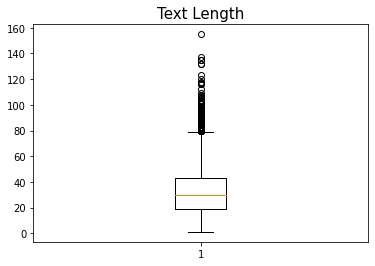

In [ ]:
plt.boxplot(texts_len)
print('25%: ', np.quantile(texts_len, q=0.25))
print('50%: ', np.quantile(texts_len, q=0.5))
print('75%: ', np.quantile(texts_len, q=0.75))
print('85%: ', np.quantile(texts_len, q=0.85))
print('90%: ', np.quantile(texts_len, q=0.9))
print('95%: ', np.quantile(texts_len, q=0.95))
print('99%: ', np.quantile(texts_len, q=0.99))
print('99.9%: ', np.quantile(texts_len, q=0.999))
plt.title('Text Length', fontsize=15)
plt.show()

- 토큰 길이

In [ ]:
tokens_len = []
for text in tqdm(train_texts):
    inputs = tokenizer(
            text, 
            return_tensors='pt',
            truncation=True,
            max_length=100,
            pad_to_max_length=True,
            add_special_tokens=True
        )
    inputs = torch.sum(inputs['attention_mask'])
    tokens_len.append(inputs)

  0%|          | 0/3001 [00:00<?, ?it/s]

25%:  10.0
50%:  13.0
75%:  19.0
85%:  22.0
90%:  25.0
95%:  29.0
99%:  40.0
99.9%:  53.0


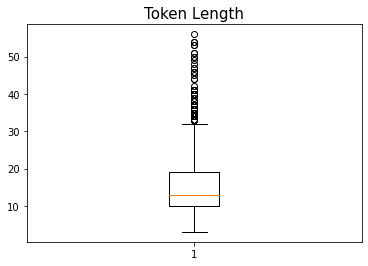

In [ ]:
plt.boxplot(tokens_len)
print('25%: ', np.quantile(tokens_len, q=0.25))
print('50%: ', np.quantile(tokens_len, q=0.5))
print('75%: ', np.quantile(tokens_len, q=0.75))
print('85%: ', np.quantile(tokens_len, q=0.85))
print('90%: ', np.quantile(tokens_len, q=0.9))
print('95%: ', np.quantile(tokens_len, q=0.95))
print('99%: ', np.quantile(tokens_len, q=0.99))
print('99.9%: ', np.quantile(tokens_len, q=0.999))
plt.title('Token Length', fontsize=15)
plt.show()

- 산점도

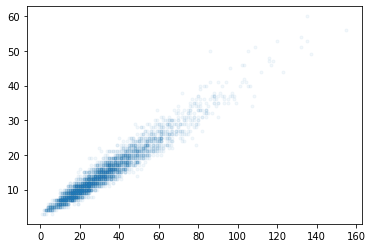

In [ ]:
plt.plot(texts_len, tokens_len, '.', alpha=0.05)

`-` $\text{토큰 길이} \times 2 \approx \text{텍스트 길이}$

## 모델 학습 방법

`-` muti class와 muti label의 차이: https://medium.com/analytics-vidhya/multi-label-classification-a9643d221954

`-` 두개의 task를 한 번에 진행할 필요는 없다 (난이도도 다르니 모델 학습 속도도 다름)

`-` 개체 속성 분류: muti label classification with single class

`-` 감성 분류: muti class classification

`-` 개체 속성 분류 train, validate ---> 감성 분류 train, validate ---> ABSA validate

`-` 개체 속성은 존재하면 1, 아니면 0으로 라벨링 ---> BCEWithlogitsloss ---> 1인 개체 속성에 대해서만 각각 감성분류

`-` 감성 분류에서는 text_pair 인자에 개체 속성을 넘겨줌 ---> CrossEntropy

`-` 개체 속성별로 긍정 데이터 개수의 균형이 맞지 않는다  

`-` 예컨대 `본품#인지도`는 3001개의 텍스트 중에서 오직 1번만 나타난다 (긍정 데이터의 개수가 1이다)

`-` 반면에 `본품#품질`의 경우 긍정 데이터가 1196개의 텍스트에 존재한다

`-` 즉, 3001개의 텍스트를 학습시키는데 `본품#인지도`는 부정(0)인 경우만 과하게 학습하고 `본품#품질`는 다른 개체 속성에 비해 긍정인 경우를 과하게 학습한다

`-` 클래스별로 가중치를 주어 클래스별로 균형있게 학습되도록 하자

`-` 또한 클래스 각각의 라벨별로 가중치를 주어 클래스별로 긍정, 부정 데이터가 균형있게 학습되도록 하자 

`-` 미니배치 단위로 학습하므로 `pos_weight` 만으로는 클래스와 라벨별로 균형있게 학습할 수 없다

`-` `본품#인지도`의 경우 1개의 긍정 라벨의 매우 큰 가중치를 주더라도 하나의 미니배치에서만 영향력을 행사하고 그 뒤로는 나머지 클래스에 의해 학습 방향이 조절된다

`-` 긍정 라벨의 개수가 30보다 작은 개체 속성에 경우 데이터가 너무 적다고 판단해 `pos_weight`를 1로 부여했다

`-` 적은 확신을 가지고 예측하는 것은 f1 score에 악영향을 끼친다

`-` 예측을 하지 않으면 FN만 1이 증가되지만 예측을 했다가 틀리면 FN, FP 둘다 1씩 증가하기 때문

`-` 따라서, 라벨 스무딩값을 작게 줘야 한다 (pos_weight도 마찬가지)

## 모델 학습 준비

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
from torch.nn.modules.loss import _Loss
from torch.optim import Optimizer

from transformers import AdamW
from transformers.optimization import get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [29]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'현재 device는 {DEVICE}입니다')

현재 device는 cuda입니다


In [30]:
def seed_everything(seed: int) -> None:
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [31]:
def clear_gpu() -> None:
    gc.collect()
    torch.cuda.empty_cache()

- 전처리

In [176]:
only_valid_entity_columns = list(set(tidy_valid['entity_property'].unique()) - set(tidy_df['entity_property'].unique()))
only_valid_entity_ids = tidy_valid.query('entity_property == @only_valid_entity_columns')['id'].to_numpy().tolist()

In [177]:
valid = valid.query('id not in @only_valid_entity_ids').reset_index().drop('index', axis=1)
tidy_valid = tidy_valid.query('id not in @only_valid_entity_ids').reset_index().drop('index', axis=1)

- 라벨 인코딩

In [34]:
ACD_ENCODER = MultiLabelBinarizer()
ACD_ENCODER.fit(df['entity_property'])

ASC_ENCODER = LabelEncoder()
ASC_ENCODER.fit(tidy_df['sentiment'])

LabelEncoder()

- 데이터 셋과 데이터 로더

In [35]:
class ACDDataset(Dataset):
    """
    개체 속성 분류
    dataframe을 df의 인자로 받는다
    """

    def __init__(
        self, 
        df: pd.DataFrame,
        tokenizer: AutoTokenizer,
        max_len: int = 128
    ) -> None:
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __getitem__(self, idx: int) -> Dict[str, List[Tensor]]:
        text = self.df.text[idx]
        entity_property = self.df.entity_property[idx]

        inputs = self.tokenizer(
            text, 
            return_tensors='pt',
            truncation=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            add_special_tokens=True
        )
                
        input_ids = inputs['input_ids'][0]
        attention_mask = inputs['attention_mask'][0]    

        if entity_property:  ## test는 라벨(개체 속성)이 없다
            if isinstance(entity_property, list):   ## untidy dataframe (for ACD)
                label = entity_property 
            elif isinstance(entity_property, str):  ## tidy dataframe (for ASC)
                label = [entity_property]
            label = torch.FloatTensor(ACD_ENCODER.transform([label]))[0]
            return {'ACD':[input_ids, attention_mask, label]}
        return {'ACD':[input_ids, attention_mask]}   

    def __len__(self) -> int:
        return self.df.shape[0]

In [36]:
class ABSADataset(Dataset):
    """
    감성 분류하면서 ABSA에 대한 평가도 진행
    tidy dataframe을 df의 인자로 받는다
    """

    def __init__(
        self, 
        df: pd.DataFrame,
        tokenizer: AutoTokenizer,
        max_len: int = 128
    ) -> None:
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __getitem__(self, idx: int) -> Dict[str, List[Tensor]]:
        text = self.df.text[idx]
        entity_property = self.df.entity_property[idx]
        sentiment = self.df.sentiment[idx]

        text_pair = ' '.join(entity_property.split('#')).replace('/', ' ') if entity_property else None
        acd_dataset = ACDDataset(self.df.iloc[[idx], :], self.tokenizer, self.max_len)[idx].get('ACD')
        inputs = self.tokenizer(
            text, 
            text_pair,
            return_tensors='pt',
            truncation=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            add_special_tokens=True
        )
                
        input_ids = inputs['input_ids'][0]
        attention_mask = inputs['attention_mask'][0]
        token_type_ids = inputs['token_type_ids'][0]

        if sentiment:
            label = torch.LongTensor(ASC_ENCODER.transform([sentiment]))[0]
            return {'ACD':acd_dataset, 
                    'ASC':[input_ids, attention_mask, token_type_ids, label]}

        return {'ACD':acd_dataset, 
                'ASC':[input_ids, attention_mask, token_type_ids]}

    def __len__(self) -> int:
        return self.df.shape[0]

- 손실 함수

In [37]:
class LabelSmoothingBCEWithLogitsLoss(nn.BCEWithLogitsLoss):
    def __init__(self,
                 weight: Optional[Tensor] = None, 
                 size_average: Optional[bool] = None, 
                 reduce: Optional[bool] = None, 
                 reduction: str = 'mean',
                 pos_weight: Optional[Tensor] = None,
                 label_smoothing: float = 0.0
    ) -> None:
        if label_smoothing < 0.0 or label_smoothing > 1.0:
           raise ValueError('label_smoothing must be between 0.0 and 1.0. Got: ', label_smoothing)

        super(LabelSmoothingBCEWithLogitsLoss, self).__init__(weight, size_average, reduce, reduction, pos_weight)
        self.label_smoothing = label_smoothing

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        smooth_target = target * (1.0 - self.label_smoothing) + 0.5*self.label_smoothing  ## single-class   
        return F.binary_cross_entropy_with_logits(input, smooth_target,
                                                  self.weight,
                                                  pos_weight=self.pos_weight,
                                                  reduction=self.reduction)

In [38]:
class FocalLoss(_Loss):
    def __init__(
        self,
        gamma: float = 2.0,
        alpha: Optional[Tensor] = None, 
        label_smoothing: float = 0.0,
        reduction: str = 'mean'
    ) -> None:
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, input: Tensor, target: Tensor) -> Tensor:
        ce_loss = F.cross_entropy(input, target, 
                                  self.alpha,
                                  label_smoothing=self.label_smoothing,
                                  reduction='none')
        p_t = torch.exp(-ce_loss)  
        loss = ce_loss * (1 - p_t)**self.gamma

        if self.reduction == 'mean':
            loss = loss.mean()
        elif self.reduction == 'sum':
            loss = loss.sum()
        return loss

In [39]:
## ACD
acd_dict = tidy_df['entity_property'].value_counts().to_dict()
acd_pos_weight = torch.FloatTensor([[(df.shape[0] - acd_dict[cls]) / acd_dict[cls] if acd_dict[cls] > 30 else 1.0 
                                     for cls in ACD_ENCODER.classes_]])  
acd_pos_weight = np.clip(acd_pos_weight, a_min=1.0, a_max=2.0)  ## 1보다 크면 recall이 올라가고 1보다 작으면 precision이 올라간다 (trade off)
acd_pos_weight = acd_pos_weight.to(DEVICE)

acd_loss_fn = LabelSmoothingBCEWithLogitsLoss(weight=None, pos_weight=acd_pos_weight, label_smoothing=LABEL_SMOOTHING)


## ASC
asc_dict = tidy_df['sentiment'].value_counts().to_dict()
asc_weight = torch.FloatTensor([1 - (asc_dict[cls] / sum(asc_dict.values())) for cls in ASC_ENCODER.classes_])
asc_weight = np.clip(asc_weight, a_min=0.25, a_max=1.0)
asc_weight = asc_weight.to(DEVICE)

# asc_loss_fn = nn.CrossEntropyLoss(weight=None, label_smoothing=LABEL_SMOOTHING)
asc_loss_fn = FocalLoss(gamma=1.0, alpha=asc_weight, label_smoothing=LABEL_SMOOTHING)

## Loss
loss_fn = {'ACD':acd_loss_fn, 'ASC':asc_loss_fn}

- early stopping

In [40]:
## Copyright (c) 2018 Bjarte Mehus Sunde
## ref: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    """주어진 patience 횟수 이후로 validation score가 개선되지 않으면 학습을 조기 중단"""
    mode_dict = {'min':-1, 'max':1}
    score_metrics = [
        'accuracy',
        'f1_score',
    ]

    def __init__(
        self, 
        patience: int = 7, 
        monitor: str = 'loss', 
        mode: str = 'min', 
        min_delta: float = 0.0, 
        path: str = './weight', 
        model_name: str = '', 
        current_fold: int = 1
    ) -> None:
        """
        Args:
            patience (int): score가 개선될 때까지 기다리는 에폭
                            Default: 7
                          
            monitor (str): 값의 변화를 모니터링할 수치(score)
                            Default: 'loss'

            mode (str): score를 개선시킬 방식
                            Default: 'min'

            min_delta (float): 개선되었다고 인정되는 score의 최소 변화
                            Default: 0.0

            path (str): checkpoint 공통 저장 경로
                            Default: './weight'

            model_name (str): 학습시킬 모델의 이름
                            Default: ''

            current_fold (int): 현재 학습을 진행하는 fold의 순서
                            Default: 1
        """
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.direction = self.mode_dict[mode]
        self.monitor = monitor
        self.best_score = -np.Inf
        self.valid_loss = np.Inf
        self.valid_metric_score = None  ## 평가지표 (i.g. accuracy)
        self.early_stop = False
        self.min_delta = min_delta
        self.path = path
        self.model_name = model_name
        self.current_fold = current_fold

    def __call__(
        self, 
        model: nn.Module, 
        valid_loss: float, 
        valid_metric_score: Optional[float] = None
    ) -> None:
        ## score는 클수록 좋다
        if self.monitor == 'loss':
            score = valid_loss * self.direction
        elif self.monitor in self.score_metrics:
            score = valid_metric_score * self.direction
        else:
            score = None

        ## score가 개선되었는지 확인
        if score <= self.best_score + self.min_delta: 
            self.counter += 1 
            if self.counter > self.patience:  ## 만약 score가 개선되지 않은 에폭이 patience 횟수보다 크다면 조기 중단
                self.early_stop = True
        else: 
            self.best_score = score 
            self.save_checkpoint(model, valid_loss, valid_metric_score) 
            self.counter = 0  ## score가 개선되었으므로 0으로 변경

    def save_checkpoint(
        self, 
        model: nn.Module, 
        valid_loss: float, 
        valid_metric_score: Optional[float] = None
    ) -> None:
        """validation score가 개선되면 모델을 저장"""
        torch.save(model.state_dict(), self.get_current_fold_path()) 
        self.valid_loss = valid_loss  ## 모델이 더 좋게 갱신되었으므로 이때의 valid loss를 기준치로 변경
        self.valid_metric_score = valid_metric_score  ## 이때의 valid metric score도 변경해준다

    def set_fold(self, current_fold: int) -> None:
        self.current_fold = current_fold

    def reset_score(self) -> None:
        """다음 fold 학습을 위해 score 관련 파라미터를 초기화"""
        self.counter = 0
        self.best_score = -np.Inf
        self.valid_loss = np.Inf
        self.valid_metric_score = None
        self.early_stop = False

    def check_early_stop(self) -> bool:
        return self.early_stop

    def get_current_fold_path(self) -> str:
        return self.path + f'/{self.model_name}_best_{self.current_fold}.pt'

    def set_path(self, path) -> None:
        self.path = path

In [41]:
early_stopping = EarlyStopping(patience=15,
                               monitor='f1_score',
                               mode='max',
                               path=SAVE_PATHS['ACD'],
                               model_name=MODEL_NAME,
                               current_fold=1)  ## patience 횟수 에폭 후에도 검증 손실이 작아지지 않으면 조기 중단

## 모델 학습 및 검증

- 텍스트

In [78]:
def under_half_max_to_1(arr, threshold=0.5):
    if np.max(arr) < threshold:
        arr[np.argmax(arr)] = 1.0
    return arr

In [51]:
def train(
        model: nn.Module,
        dataloader: DataLoader, 
        task_type: str,
        device: torch.device,
        loss_fn: _Loss, 
        optimizer: Optimizer, 
        scheduler: Optional[_LRScheduler] = None
    ) -> Tuple[nn.Module, float]:
    """dataloader의 데이터로 모델을 학습시킨 후 학습된 모델과 평균 배치 훈련 오차를 반환"""  
    train_loss = 0.0  ## mini-batch 평균 훈련 오차 
    model.to(device)
    model.train()
    scaler = torch.cuda.amp.GradScaler()

    for batch in dataloader:  ## 미니 배치 단위로 꺼내온다
        *args, y = [*(map(lambda tensor: tensor.to(device), batch[task_type]))]
        with torch.cuda.amp.autocast():
            y_hat = model(*args)[0]
            loss = loss_fn(y_hat, y)  

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()  ## 그래디언트 초기화
        train_loss += (loss.item() / len(dataloader)) 
  
        ## 배치마다 학습률 조절
        if scheduler is not None:
            scheduler.step()
        
    return model, train_loss

In [52]:
def acd_evaluate(
        model: nn.Module, 
        dataloader: DataLoader, 
        loss_fn: _Loss,
        device: torch.device
    ) -> Tuple[float, float]:
    """dataloader의 데이터를 모델이 평가한 후 평균 배치 검증 오차와 ACD f1 score를 반환"""
    valid_loss = 0.0
    y_array, yhat_array = np.array([]), np.array([])
    model.to(device)
    model.eval()  

    with torch.no_grad():  ## 역전파를 계산할 필요가 없으니까
        for batch in dataloader:  ## 미니 배치 단위로 꺼내온다
            *args, y = [*(map(lambda tensor: tensor.to(device), batch['ACD']))]
            y_hat = model(*args)[0]
            loss = loss_fn(y_hat, y) 
            
            y_hat = F.sigmoid(y_hat).detach().cpu().numpy()
            # y_hat = np.apply_along_axis(under_half_max_to_1, 1, y_hat)  ## 텍스트에는 적어도 한 개의 개체 속성이 포함되어야 한다 (모든 train text는 한 개 이상의 개체 속성을 포함)
            y_hat = np.where(y_hat >= 0.5, 1, 0) 

            y_array = np.concatenate([y_array, y.detach().cpu().numpy().reshape(-1)], axis=0)
            yhat_array = np.concatenate([yhat_array, y_hat.reshape(-1)], axis=0)
            valid_loss += (loss.item() / len(dataloader))
            
    valid_precision = precision_score(y_array, yhat_array)
    valid_recall = recall_score(y_array, yhat_array)
    valid_f1 = f1_score(y_array, yhat_array)
    return valid_loss, valid_precision, valid_recall, valid_f1

In [53]:
def absa_evaluate(
        acd_model: nn.Module,
        asc_model: nn.Module,  
        dataloader: DataLoader,
        acd_model_weight_path: str,
        loss_fn: _Loss,
        device: torch.device
    ) -> Tuple[float, float, float]:
    """dataloader의 데이터를 모델이 평가한 후 평균 배치 검증 오차와 (ACD, ABSA) f1 score를 반환"""
    valid_loss = 0.0
    asc_y_array, asc_yhat_array = np.array([]), np.array([])
    absa_y_array, absa_yhat_array = np.array([]), np.array([])
    acd_model.load_state_dict(torch.load(acd_model_weight_path , map_location=device))
    acd_model.to(device)
    asc_model.to(device)
    acd_model.eval()
    asc_model.eval() 

    with torch.no_grad():  ## 역전파를 계산할 필요가 없다
        for batch in dataloader:  ## 미니 배치 단위로 꺼내온다
            *acd_args, acd_y = [*(map(lambda tensor: tensor.to(device), batch['ACD']))]
            *asc_args, asc_y = [*(map(lambda tensor: tensor.to(device), batch['ASC']))]
            acd_y = acd_y.detach().cpu().numpy()  ## shape: (B, C)
            
            acd_yhat = F.sigmoid(acd_model(*acd_args)[0]).detach().cpu().numpy()
            # acd_yhat = np.apply_along_axis(under_half_max_to_1, 1, acd_yhat)   ## 텍스트에는 적어도 한 개의 개체 속성이 포함되어야 한다
            acd_yhat = np.where(acd_yhat >= 0.5, 1, 0)  ## shape: (B, C)
            asc_yhat = asc_model(*asc_args)[0]
            loss = loss_fn(asc_yhat, asc_y)  
            asc_yhat = asc_yhat.argmax(-1).detach().cpu().numpy()

            ## 개체 속성이 틀리다면 감성은 굳이 확인하지 않아도 된다
            ## 개체 속성이 맞지만 감성이 틀렸다면 FP, FN 둘 다 1씩 증가시켜야 한다
            ## true: [1(긍정), 0, 0, 0], pred: [1(긍정 X), 0, 0, 0] 
            ## 위와 같은 상황일 때 true: [1, 0, 0, 0], pred: [0, 0, 0, 0]와 같이 라벨링 하면 FN는 1이 증가하지만 FP는 증가하지 않음 
            ## true(긍정, 긍정X): [[1, 0, 0, 0], [0, 0, 0, 0]] , pred(긍정, 긍정X): [[0, 0, 0, 0], [1, 0, 0, 0]], 따라서 이와 같이 라벨링 
            ## 근데 위와 같이 차원의 낭비이고 단지 FP, FN만 1씩 증가시키면 된다
            ## true: [1, 0, 0, 0] + [0] , pred: [0, 0, 0, 0] + [1], 따라서 이와 같이 라벨링
            ## 근데 이렇게하면 차원이 안맞아서 차원을 하나 더 만들었다
            for idx in range(len(acd_y)):
                one_idx = np.where(acd_y[idx] == 1)  
                if acd_yhat[idx][one_idx][0] == 1:   ## 개체 속성을 맞춘 경우
                    if asc_y[idx] != asc_yhat[idx]:  ## 감성을 틀린 경우
                        tmp_y = np.zeros_like(acd_y[idx])
                        tmp_yhat = np.zeros_like(acd_yhat[idx])
                        acd_yhat[idx][one_idx] = 0   ## FN
                        tmp_yhat[one_idx] = 1        ## FP
                        acd_y = np.concatenate([acd_y, tmp_y.reshape(1, -1)], axis=0)
                        acd_yhat = np.concatenate([acd_yhat, tmp_yhat.reshape(1, -1)], axis=0)

            asc_y_array = np.concatenate([asc_y_array, asc_y.detach().cpu().numpy()], axis=0)
            asc_yhat_array = np.concatenate([asc_yhat_array, asc_yhat], axis=0)
            absa_y_array = np.concatenate([absa_y_array, acd_y.reshape(-1)], axis=0)
            absa_yhat_array = np.concatenate([absa_yhat_array, acd_yhat.reshape(-1)], axis=0)
            valid_loss += (loss.item() / len(dataloader))

    asc_valid_f1 = f1_score(asc_y_array, asc_yhat_array, average='macro')  ## 감성(긍정, 부정, 중립)
    absa_valid_f1 = f1_score(absa_y_array, absa_yhat_array)
    return valid_loss, asc_valid_f1, absa_valid_f1

In [54]:
def deep_ensemble(
        models: Dict[str, nn.Module], 
        acd_train_df: pd.DataFrame,
        acd_valid_df: pd.DataFrame,
        absa_train_df: pd.DataFrame,
        absa_valid_df: pd.DataFrame,
        tokenizer: AutoTokenizer,
        loss_fn: Dict[str, _Loss], 
        early_stopping: EarlyStopping,
        seeds: List[int],
        device: torch.device
    ) -> Tuple[Dict[str, nn.Module], List[List[float]], List[List[float]], List[List[float]], List[List[float]]]:
    """
    K겹 교차검증을 통해 모델의 성능을 평가하고 학습된 모델과 폴드별 훈련 손실, 폴드별 검증 손실을 반환
    개체 속성 분류에 대해서만 학습과 검증 후 감성 분류에 대해서 학습과 검증 그리고 ABSA 평가를 진행
     """
    num_folds = len(seeds)   
    acd_fold_train_losses_per_epoch = [[] for _ in range(num_folds)]  ## ACD: 폴드별 1 에폭에 따른 훈련 배치 손실
    acd_fold_valid_losses_per_epoch = [[] for _ in range(num_folds)]  ## ACD: 폴드별 1 에폭에 따른 검증 배치 손실
    asc_fold_train_losses_per_epoch = [[] for _ in range(num_folds)]  ## ASC
    asc_fold_valid_losses_per_epoch = [[] for _ in range(num_folds)]  ## ASC

    for fold, seed in enumerate(seeds):
        seed_everything(seed)  ## 정확한 재현을 위함
        print(f'[{fold + 1} / {num_folds}] Fold Training......')

        ## 메모리 절약
        clear_gpu()

        ## Dataloader
        train_dataloader = {'ACD':DataLoader(ACDDataset(acd_train_df, tokenizer, MAX_LEN), batch_size=BATCH_SIZE, shuffle=True),
                            'ASC':DataLoader(ABSADataset(absa_train_df, tokenizer, MAX_LEN), batch_size=BATCH_SIZE, shuffle=True)}

        valid_dataloader = {'ACD':DataLoader(ACDDataset(acd_valid_df, tokenizer, MAX_LEN), batch_size=BATCH_SIZE),
                            'ASC':DataLoader(ABSADataset(absa_valid_df, tokenizer, MAX_LEN), batch_size=BATCH_SIZE)}        

        ## ACD, ASC 모델의 기본 가중치 불러오기
        acd_model, asc_model = models['ACD'], models['ASC']
        acd_model.load_state_dict(torch.load(MODEL_DEFAULT_WEIGHT_PATHS['ACD'], map_location=device))
        asc_model.load_state_dict(torch.load(MODEL_DEFAULT_WEIGHT_PATHS['ASC'], map_location=device))

        ## optimizer
        optimizer = {'ACD':AdamW(acd_model.parameters(), lr=LEARNING_RATE['ACD']),
                     'ASC':AdamW(asc_model.parameters(), lr=LEARNING_RATE['ASC'])}

        ## scheduler
        t_total = len(train_dataloader['ACD']) * NUM_EPOCHS['ACD']  ## The total number of training steps
        warmup_step = t_total // 10  ## The number of steps for the warmup phase
        scheduler = {'ACD':get_linear_schedule_with_warmup(optimizer['ACD'], num_warmup_steps=warmup_step, num_training_steps=t_total),
                     'ASC':get_linear_schedule_with_warmup(optimizer['ASC'], num_warmup_steps=warmup_step, num_training_steps=t_total)}

        ## early stop, 다음 폴드 학습을 위해 score 관련 파라미터 초기화
        early_stopping.reset_score()
        early_stopping.set_path(SAVE_PATHS['ACD'])
        early_stopping.set_fold(fold + 1)  
        
        ## 폴드마다 ACD 모델 학습
        task = 'ACD'
        print(f'{"#"*32}  {task}  {"#"*32}')
        for epoch in tqdm(range(1, NUM_EPOCHS[task]+1)): ## (배치사이즈 X 에폭) 만큼 훈련시킴           
            acd_model, train_loss = train(acd_model, train_dataloader[task], task, device, 
                                      loss_fn[task], optimizer[task], scheduler[task])  ## 모델 학습

            valid_loss, valid_precision, valid_recall, valid_f1 = acd_evaluate(acd_model, valid_dataloader[task], loss_fn[task], device)  ## 모델 평가
            acd_fold_train_losses_per_epoch[fold].append(train_loss) 
            acd_fold_valid_losses_per_epoch[fold].append(valid_loss)  

            print_score_condition = (epoch == 1 or epoch % 5 == 0 or epoch == NUM_EPOCHS[task])  
            score_information = f'[Epoch: {epoch:>2}]  train loss = {train_loss:.5f}  valid loss = {valid_loss:.5f}  precision = {valid_precision:.5f}  recall = {valid_recall:.5f}  f1 = {valid_f1:.5f}'

            ## 평균 배치 훈련 오차와 검증 오차 출력
            if print_score_condition:  
                print(score_information)  
                
            ## 에폭마다 early stopping 실행
            early_stopping(acd_model, valid_loss, valid_f1)  
            if early_stopping.check_early_stop(): 
                if not print_score_condition:  ## 이미 출력한 에폭에 대해 중복으로 출력하지 않기 위함
                    print(score_information) 
                print('Early Stopping!')
                break 
 
        ## ACD: 폴드별 학습 및 검증 종료시 가장 작은 검증 손실과 이때의 f1 score를 출력
        print(f'{fold + 1} Fold -> Best Valid Loss: {early_stopping.valid_loss:.5f} Valid ACD F1 score: {early_stopping.valid_metric_score:.5f}', end='\n\n')
        
        ## 폴드마다 ASC 모델 학습
        early_stopping.reset_score()
        early_stopping.set_path(SAVE_PATHS['ASC'])
        task = 'ASC'
        print(f'{"#"*32}  {task}  {"#"*32}')
        for epoch in tqdm(range(1, NUM_EPOCHS[task]+1)): ## (배치사이즈 X 에폭) 만큼 훈련시킴         
            asc_model, train_loss = train(asc_model, train_dataloader[task], task, device, 
                                      loss_fn[task], optimizer[task], scheduler[task])  ## 모델 학습

            valid_loss, asc_valid_f1, absa_valid_f1 = absa_evaluate(acd_model, asc_model, valid_dataloader[task], 
                                                                    f'{SAVE_PATHS["ACD"]}/{MODEL_NAME}_best_{fold + 1}.pt', 
                                                                    loss_fn[task], device)  ## 모델 평가

            asc_fold_train_losses_per_epoch[fold].append(train_loss) 
            asc_fold_valid_losses_per_epoch[fold].append(valid_loss)  
  
            print_score_condition = (epoch == 1 or epoch % 5 == 0 or epoch == NUM_EPOCHS[task])  
            score_information = f'[Epoch: {epoch:>2}]  train loss = {train_loss:.5f}  valid loss = {valid_loss:.5f}  ASC macro f1 = {asc_valid_f1:.5f}  ABSA f1 = {absa_valid_f1:.5f}'

            ## 평균 배치 훈련 오차와 검증 오차 출력
            if print_score_condition:  
                print(score_information)  
                
            ## 에폭마다 early stopping 실행
            early_stopping(asc_model, valid_loss, asc_valid_f1)  
            if early_stopping.check_early_stop(): 
                if not print_score_condition: 
                    print(score_information) 
                print('Early Stopping!')
                break  

        ## ABSA: 폴드별 학습 및 검증 종료시 가장 작은 검증 손실과 이때의 f1 score를 출력
        print(f'{fold + 1} Fold -> Best Valid Loss: {early_stopping.valid_loss:.5f} Valid ASC F1 score: {early_stopping.valid_metric_score:.5f}', end='\n\n')

    models['ACD'], models['ASC'] = acd_model, asc_model
    return models, acd_fold_train_losses_per_epoch, acd_fold_valid_losses_per_epoch, asc_fold_train_losses_per_epoch, asc_fold_valid_losses_per_epoch

- 모델 선언 및 가중치 저장

In [55]:
acd_model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATHS[MODEL_NAME], num_labels=NUM_CLASSES['ACD'])
asc_model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATHS[MODEL_NAME], num_labels=NUM_CLASSES['ASC'])
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATHS[MODEL_NAME])  

Some weights of the model checkpoint at kykim/bert-kor-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

In [56]:
special_tokens_dict = {'additional_special_tokens': ['&name&', '&online-account&']}
tokenizer.add_special_tokens(special_tokens_dict)

2

In [57]:
acd_model.resize_token_embeddings(len(tokenizer))
asc_model.resize_token_embeddings(len(tokenizer))
# torch.save(acd_model.state_dict(), MODEL_DEFAULT_WEIGHT_PATHS['ACD']) 
# torch.save(asc_model.state_dict(), MODEL_DEFAULT_WEIGHT_PATHS['ASC']) 

Embedding(42002, 768)

In [58]:
models = {'ACD':acd_model, 'ASC':asc_model}

- 모델 K겹 교차검증

`-` 19시 30분 시작

In [59]:
(models, acd_fold_train_losses_per_epoch, acd_fold_valid_losses_per_epoch,
asc_fold_train_losses_per_epoch, asc_fold_valid_losses_per_epoch) = deep_ensemble(models, 
                                                                                  df,
                                                                                  valid,
                                                                                  tidy_df,
                                                                                  tidy_valid, 
                                                                                  tokenizer, 
                                                                                  loss_fn,
                                                                                  early_stopping,
                                                                                  SEEDS,
                                                                                  DEVICE)

[1 / 3] Fold Training......
################################  ACD  ################################


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.61632  valid loss = 0.44332  precision = 0.45359  recall = 0.33045  f1 = 0.38235
[Epoch:  5]  train loss = 0.32486  valid loss = 0.32822  precision = 0.71781  recall = 0.70753  f1 = 0.71263
[Epoch: 10]  train loss = 0.28075  valid loss = 0.33325  precision = 0.72809  recall = 0.72785  f1 = 0.72797
[Epoch: 15]  train loss = 0.27153  valid loss = 0.33728  precision = 0.72860  recall = 0.72885  f1 = 0.72873
[Epoch: 20]  train loss = 0.26855  valid loss = 0.33710  precision = 0.72804  recall = 0.74550  f1 = 0.73667
[Epoch: 25]  train loss = 0.26715  valid loss = 0.33918  precision = 0.72579  recall = 0.74151  f1 = 0.73356
[Epoch: 30]  train loss = 0.26662  valid loss = 0.34050  precision = 0.72399  recall = 0.74184  f1 = 0.73281
[Epoch: 35]  train loss = 0.26630  valid loss = 0.34133  precision = 0.72219  recall = 0.74384  f1 = 0.73285
[Epoch: 37]  train loss = 0.26625  valid loss = 0.34114  precision = 0.72365  recall = 0.74317  f1 = 0.73328
Early Stopping!
1 F

  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.11058  valid loss = 0.08039  ASC macro f1 = 0.33967  ABSA f1 = 0.68166
[Epoch:  5]  train loss = 0.07045  valid loss = 0.06481  ASC macro f1 = 0.52049  ABSA f1 = 0.67573
[Epoch: 10]  train loss = 0.04427  valid loss = 0.06396  ASC macro f1 = 0.58214  ABSA f1 = 0.66979
[Epoch: 15]  train loss = 0.03885  valid loss = 0.06608  ASC macro f1 = 0.63490  ABSA f1 = 0.68322
[Epoch: 20]  train loss = 0.03756  valid loss = 0.06625  ASC macro f1 = 0.62345  ABSA f1 = 0.68322
1 Fold -> Best Valid Loss: 0.06497 Valid ASC F1 score: 0.64100

[2 / 3] Fold Training......
################################  ACD  ################################


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.61700  valid loss = 0.44328  precision = 0.42171  recall = 0.40373  f1 = 0.41253
[Epoch:  5]  train loss = 0.32566  valid loss = 0.32923  precision = 0.73880  recall = 0.67555  f1 = 0.70576
[Epoch: 10]  train loss = 0.28043  valid loss = 0.33343  precision = 0.73275  recall = 0.72152  f1 = 0.72709
[Epoch: 15]  train loss = 0.27176  valid loss = 0.33769  precision = 0.71821  recall = 0.73185  f1 = 0.72496
[Epoch: 20]  train loss = 0.26841  valid loss = 0.33841  precision = 0.72251  recall = 0.73984  f1 = 0.73107
[Epoch: 25]  train loss = 0.26731  valid loss = 0.33985  precision = 0.72503  recall = 0.73518  f1 = 0.73007
[Epoch: 30]  train loss = 0.26668  valid loss = 0.33987  precision = 0.72855  recall = 0.74117  f1 = 0.73481
[Epoch: 35]  train loss = 0.26633  valid loss = 0.34074  precision = 0.72751  recall = 0.73817  f1 = 0.73280
[Epoch: 37]  train loss = 0.26626  valid loss = 0.34070  precision = 0.72638  recall = 0.73751  f1 = 0.73190
Early Stopping!
2 F

  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.11125  valid loss = 0.08032  ASC macro f1 = 0.33998  ABSA f1 = 0.68143
[Epoch:  5]  train loss = 0.06956  valid loss = 0.06392  ASC macro f1 = 0.55368  ABSA f1 = 0.67734
[Epoch: 10]  train loss = 0.04388  valid loss = 0.06412  ASC macro f1 = 0.60636  ABSA f1 = 0.66981
[Epoch: 15]  train loss = 0.03864  valid loss = 0.06601  ASC macro f1 = 0.65310  ABSA f1 = 0.68048
[Epoch: 20]  train loss = 0.03777  valid loss = 0.06642  ASC macro f1 = 0.64464  ABSA f1 = 0.68111
2 Fold -> Best Valid Loss: 0.06601 Valid ASC F1 score: 0.65310

[3 / 3] Fold Training......
################################  ACD  ################################


  0%|          | 0/40 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.61613  valid loss = 0.44338  precision = 0.47239  recall = 0.31346  f1 = 0.37685
[Epoch:  5]  train loss = 0.32539  valid loss = 0.32941  precision = 0.72916  recall = 0.69054  f1 = 0.70932
[Epoch: 10]  train loss = 0.28061  valid loss = 0.33367  precision = 0.72155  recall = 0.71819  f1 = 0.71987
[Epoch: 15]  train loss = 0.27160  valid loss = 0.33913  precision = 0.72040  recall = 0.72352  f1 = 0.72195
[Epoch: 20]  train loss = 0.26859  valid loss = 0.33901  precision = 0.72130  recall = 0.73884  f1 = 0.72997
[Epoch: 24]  train loss = 0.26722  valid loss = 0.34281  precision = 0.71720  recall = 0.72652  f1 = 0.72183
Early Stopping!
3 Fold -> Best Valid Loss: 0.32779 Valid ACD F1 score: 0.73512

################################  ASC  ################################


  0%|          | 0/20 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.11018  valid loss = 0.08018  ASC macro f1 = 0.32843  ABSA f1 = 0.68370
[Epoch:  5]  train loss = 0.07026  valid loss = 0.06470  ASC macro f1 = 0.47822  ABSA f1 = 0.67992
[Epoch: 10]  train loss = 0.04373  valid loss = 0.06460  ASC macro f1 = 0.59571  ABSA f1 = 0.67834
[Epoch: 15]  train loss = 0.03839  valid loss = 0.06684  ASC macro f1 = 0.62308  ABSA f1 = 0.68434
[Epoch: 20]  train loss = 0.03785  valid loss = 0.06707  ASC macro f1 = 0.64264  ABSA f1 = 0.68434
3 Fold -> Best Valid Loss: 0.06707 Valid ASC F1 score: 0.64264



- train loss와 valid loss의 변화를 시각화

In [60]:
def show_loss_plot(
        fold_train_losses: List[List[float]],
        fold_valid_losses: List[List[float]]
    ) -> None:
    """폴드별로 에폭에 따른 모델의 훈련 손실과 검증 손실의 변화를 시각화"""
    assert len(fold_train_losses) == len(fold_valid_losses)
    num_folds = len(fold_train_losses)
    ncols = 3
    nrows = 1 + (num_folds - 1)//ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4)) 

    ## 폴드마다 에폭에 따른 훈련 손실과 검증 손실의 변화를 시각화
    for fold, (ax, train_losses, valid_losses) in enumerate(zip(axes.flatten(), fold_train_losses, fold_valid_losses), start=1):
        assert len(train_losses) == len(valid_losses) 
        if fold > num_folds:
            break

        num_epochs = len(train_losses)
        ax.set_title(f'{fold} Fold')
        ax.plot(range(1, num_epochs+1), train_losses, label='Train')
        ax.plot(range(1, num_epochs+1), valid_losses, label='Valid')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()

    fig.suptitle('Train Loss and Valid Loss', x=0.51, y=1.05, fontsize=15)
    fig.tight_layout()

    ## 남는 서브 플랏 제거
    for ax in axes.flatten():
        if not ax.has_data():
            fig.delaxes(ax)

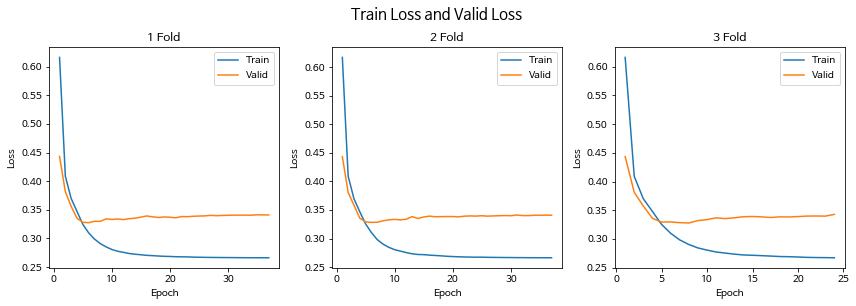

In [61]:
show_loss_plot(acd_fold_train_losses_per_epoch, acd_fold_valid_losses_per_epoch)

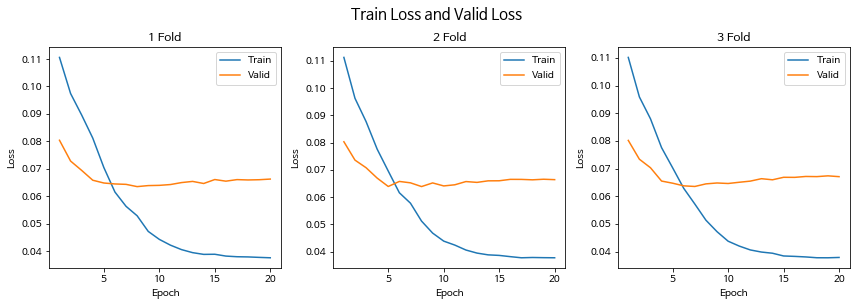

In [62]:
show_loss_plot(asc_fold_train_losses_per_epoch, asc_fold_valid_losses_per_epoch)

## Test 예측

In [87]:
def acd_predict(
        model: nn.Module, 
        dataloader: DataLoader, 
        weight_save_path: str, 
        device: torch.device,
        return_prob: bool = False
    ) -> Tensor:
    """test text를 보고 개체 속성을 분류"""
    model.to(device) 
    weight_path_list = glob(weight_save_path + '/*.pt')
    test_probs = torch.zeros(len(dataloader.dataset), NUM_CLASSES['ACD'])  

    for weight_path in tqdm(weight_path_list):
        probs = None
        model.load_state_dict(torch.load(weight_path, map_location=device))
        model.eval()

        with torch.no_grad(): 
            for batch in dataloader:  ## test 데이터는 라벨(y)이 없다
                args = [*(map(lambda tensor: tensor.to(device), batch['ACD']))]
                y_hat = F.sigmoid(model(*args)[0]).detach().cpu().numpy()

                if probs is None:
                    probs = y_hat
                else:
                    probs = np.concatenate([probs, y_hat]) 

        test_probs += (torch.from_numpy(probs) / NUM_FOLDS)    ## 각 컬럼별 확률
    # test_probs = torch.from_numpy(np.apply_along_axis(under_half_max_to_1, 1, test_probs))  ## 텍스트에는 적어도 한 개의 개체 속성이 포함되어야 한다
    test_preds = torch.where(test_probs >= 0.5, 1, 0)          ## threshold(0.5)보다 크면 positive 그렇지 않으면 negative

    if return_prob:
        return test_probs  ## 각 컬럼별 확률
    return test_preds  ## 라벨

In [64]:
def asc_predict(
        model: nn.Module, 
        dataloader: DataLoader, 
        weight_save_path: str, 
        device: torch.device,
        return_prob: bool = False
    ) -> Tensor:
    """개체 속성을 분류한 후 존재하는 개체 속성에 대해 감성 분류"""
    model = model.to(device) 
    weight_path_list = glob(weight_save_path + '/*.pt') 
    test_probs = torch.zeros(len(dataloader.dataset), NUM_CLASSES['ASC'])  

    for weight_path in tqdm(weight_path_list):
        probs = None
        model.load_state_dict(torch.load(weight_path, map_location=device))
        model.eval()

        with torch.no_grad(): 
            for batch in dataloader:  ## test 데이터는 라벨(y)이 없다
                args = [*(map(lambda tensor: tensor.to(device), batch['ASC']))]
                y_hat = model(*args)[0].detach().cpu().numpy()

                if probs is None:
                    probs = y_hat
                else:
                    probs = np.concatenate([probs, y_hat]) 

        test_probs += (torch.softmax(torch.from_numpy(probs), dim=-1) / NUM_FOLDS)  ## 각 컬럼별 확률
    _, test_preds = torch.max(test_probs, dim=-1)  ## 최댓값과 인덱스
    
    if return_prob:
        return test_probs  ## 각 컬럼별 확률
    return test_preds  ## 라벨

In [65]:
def fill_annotation(jsonl: List[JsonType], df: pd.DataFrame) -> List[JsonType]:
    """
    test jsonl의 annotation을 df의 entity_property와 sentiment로 채운다 (In-Place)
    For submission 
    """
    list_df = df.to_numpy().tolist()
    for idx, json in enumerate(jsonl):
        assert json['id'].split('-')[-1] == list_df[idx][0]  ## id는 동일해야 함
        jsonl[idx]['annotation'] = list(map(list, zip(list_df[idx][2], list_df[idx][3])))  ## entity_property, sentiment    
    return jsonl

In [178]:
test_acd_dataloader = DataLoader(ACDDataset(test, tokenizer, MAX_LEN), batch_size=BATCH_SIZE)

In [179]:
acd_preds = acd_predict(acd_model, test_acd_dataloader, SAVE_PATHS['ACD'], device=DEVICE)

  0%|          | 0/3 [00:00<?, ?it/s]

In [180]:
test['entity_property'] = list(map(list, ACD_ENCODER.inverse_transform(acd_preds)))
test = to_tidy(test)

In [182]:
none_entity_test = test[test['entity_property'].apply(lambda x: False if x else True)]  ## sentiment == []
test = test[test['entity_property'].apply(lambda x: True if x else False)].reset_index().drop('index', axis=1)

In [183]:
test_absa_dataloader = DataLoader(ABSADataset(test, tokenizer, MAX_LEN), batch_size=BATCH_SIZE)

In [184]:
asc_preds = asc_predict(asc_model, test_absa_dataloader, SAVE_PATHS['ASC'], device=DEVICE)
test['sentiment'] =  ASC_ENCODER.inverse_transform(asc_preds)

  0%|          | 0/3 [00:00<?, ?it/s]

In [191]:
test = pd.concat([test, none_entity_test], axis=0)
test = test.sort_values(by=['id']).reset_index().drop('index', axis=1)

In [235]:
test = to_untidy(test)

In [238]:
test_jsonl = fill_annotation(load_jsonl(test_path) , test)

In [239]:
write_jsonl(test_jsonl, submission_path)

In [249]:
x = to_tidy(test)
x = x[x['entity_property'].apply(lambda x: True if x else False)].reset_index().drop('index', axis=1)

In [250]:
x.entity_property.value_counts() / x.shape[0]

본품#품질          0.339656
제품 전체#일반       0.175121
본품#일반          0.114689
본품#편의성         0.091310
제품 전체#디자인      0.077195
제품 전체#품질       0.074107
제품 전체#편의성      0.035730
제품 전체#가격       0.026908
패키지/구성품#디자인    0.020291
제품 전체#인지도      0.014557
패키지/구성품#편의성    0.011028
패키지/구성품#일반     0.010587
브랜드#일반         0.005734
본품#다양성         0.003088
Name: entity_property, dtype: float64

In [251]:
tidy_df.entity_property.value_counts() / tidy_df.shape[0]

본품#품질          0.360963
제품 전체#일반       0.265249
본품#일반          0.078198
제품 전체#품질       0.074132
제품 전체#디자인      0.049109
제품 전체#편의성      0.029403
본품#편의성         0.029403
제품 전체#인지도      0.020644
브랜드#일반         0.016578
패키지/구성품#디자인    0.016578
제품 전체#가격       0.015327
패키지/구성품#편의성    0.011886
패키지/구성품#일반     0.009384
본품#다양성         0.006256
본품#디자인         0.004692
브랜드#품질         0.004066
패키지/구성품#품질     0.003128
브랜드#인지도        0.002815
브랜드#가격         0.000938
본품#가격          0.000626
패키지/구성품#다양성    0.000313
본품#인지도         0.000313
Name: entity_property, dtype: float64

In [252]:
tidy_valid.entity_property.value_counts() / tidy_valid.shape[0]

본품#품질          0.375957
제품 전체#일반       0.257409
제품 전체#품질       0.080919
본품#일반          0.076923
제품 전체#디자인      0.041958
본품#편의성         0.031302
제품 전체#편의성      0.028638
제품 전체#인지도      0.024975
패키지/구성품#디자인    0.020979
브랜드#일반         0.016650
제품 전체#가격       0.014319
패키지/구성품#편의성    0.008991
패키지/구성품#일반     0.006660
본품#다양성         0.003330
브랜드#인지도        0.002664
패키지/구성품#품질     0.002331
본품#디자인         0.001998
브랜드#품질         0.001998
브랜드#가격         0.001332
패키지/구성품#다양성    0.000666
Name: entity_property, dtype: float64